In [17]:
import nibabel
import os
from pathlib import Path
import numpy as np

In [95]:
def parse_labels(raw_csv_file, output_file):
    
    import csv
    csv_columns = ['run','trial','global time', 'run time', 'morph level', 'couple', 'response', 'response time']
    csv_file = output_file
    
    f = open(raw_csv_file)
    all_lines = f.readlines()
    
    to_be_added = []
    morph_level = None
    couple = None
    is_complete = False
    new_morph = False
    nb_item = 0
    nb_run = 0
    first_morph = True
    
    def get_indices(all_lines, to_find='Debut_run '):
        indices = []
        for count, line in enumerate(all_lines):
            if line.find(to_find) > -1:
                indices += [count]
        return indices + [len(all_lines)]
    
    run_starts = get_indices(all_lines, 'Debut_run ')
    
    for nb_run in range(len(run_starts) - 1):
        
        run_start = run_starts[nb_run]
        run_stop = run_starts[nb_run + 1]
        
        sub_lines = all_lines[run_start:run_stop]
        
        for line in sub_lines:
            if line.find('Synchro_IRM') > -1:
                global_t_start = int(line.split(',')[0])

        morph_starts = get_indices(sub_lines, 'MORPH')
        morph_starts += [run_stop - morph_starts[-1]]
        
        for nb_item in range(len(morph_starts)-1):
        
            morph_start = morph_starts[nb_item]
            morph_stop = morph_starts[nb_item + 1]
            response = 0
            response_time = None
        
            for line in sub_lines[morph_start:morph_stop]:
                if line.find('morph_') > -1:
                    file_name = line.split(',')[3].split(' ')[1]
                    file_name = file_name.split("\\")[2]
                    morph_level = int(file_name.split('_')[1])
                    couple = int(file_name.split('_')[2].split('.')[0])
                    t_start = int(line.split(',')[3].split(' ')[2])

                if line.find('bouton_1') > -1:
                    response = 1
                    response_time = int(line.split(',')[3].split(' ')[1]) + 500

            to_add = {'run' : nb_run + 1, 
                      'trial' : nb_item + 1,
                       'global time' : t_start, 
                       'run time' :  t_start - global_t_start,
                       'morph level' : morph_level,
                       'couple' : couple, 
                       'response' : response, 
                       'response time' : response_time}
            to_be_added += [to_add]

    try:
        with open(output_file, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
            writer.writeheader()
            for data in to_be_added:
                writer.writerow(data)
    except IOError:
        print("I/O error")

In [129]:
for file in os.listdir(Path("labels/raw")):
    parse_labels(Path("labels/raw") / file, Path("labels") / file)

In [130]:
def view_results(subject=1, run='all', return_data=False):

    import pandas
    from pathlib import Path

    labels = pandas.read_csv(f'labels/labels_{subject}.csv')
    
    if run == 'all':
        x = labels['morph level']
        y = labels['response']
        z = labels['response time']
    elif run in range(1, 5):
        mask = labels['run'] == run
        x = labels[mask]['morph level']
        y = labels[mask]['response']
        z = labels[mask]['response time']
    
    import pylab as plt
    values, counts = np.unique(x, return_counts=True)

    results = {}
    results['response'] = {'mean' : np.zeros(len(values)), 'std' : np.zeros(len(values))}
    results['response_time'] = {'mean' : np.zeros(len(values)), 'std' : np.zeros(len(values))}
    for count, v in enumerate(values):
        mask = (x == v)
        results['response']['mean'][count] = np.mean(y[mask])
        results['response']['std'][count] = np.std(y[mask])/np.sqrt(np.sum(mask))

        results['response_time']['mean'][count] = np.mean(z[mask])
        results['response_time']['std'][count] = np.std(z[mask])/np.sqrt(np.sum(mask))

    fig, ax = plt.subplots(ncols=2, squeeze=False, figsize=(15,5))
    ax[0,0].plot(values, results['response']['mean'])
    ax[0,0].fill_between(values, results['response']['mean'] - results['response']['std'], 
                     results['response']['mean'] + results['response']['std'], alpha=0.25)
    ax[0,0].set_xlabel('% morph')
    ax[0,0].set_ylabel('response')

    ax[0,1].plot(values, results['response_time']['mean'])
    ax[0,1].fill_between(values, results['response_time']['mean'] - results['response_time']['std'], 
                     results['response_time']['mean'] + results['response_time']['std'], alpha=0.25)
    ax[0,1].set_xlabel('% morph')
    ax[0,1].set_ylabel('response time (ms)')
    
    if return_data:
        return results

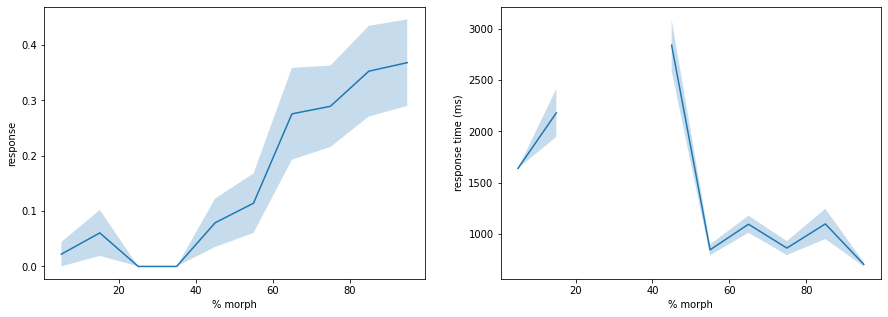

In [134]:
results = view_results(23, return_data=True)

In [128]:
results

{'response': {'mean': array([0.30952381, 0.33333333, 0.57575758, 0.8       , 0.90697674,
         0.92105263, 1.        , 0.94444444, 0.92307692, 0.97222222]),
  'std': array([0.07133403, 0.07548514, 0.08603396, 0.07302967, 0.0442955 ,
         0.04374408, 0.        , 0.0381769 , 0.04266925, 0.02738926])},
 'response_time': {'mean': array([956.76923077, 789.84615385, 794.63157895, 998.125     ,
         732.02564103, 738.45714286, 662.08823529, 869.05882353,
         716.33333333, 756.88571429]),
  'std': array([ 97.47038911,  21.88420721,  53.68694211, 167.37210965,
          46.15328596,  84.17524097,  30.39330899, 130.15094895,
          49.91564109,  72.0991686 ])}}